# Clustering

This notebook tests K-means and Agglomerative heirarchical clustering algorithms to cluster census tracts in the Boston area.

In [359]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
import numpy as np

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import Clustering_Helper_Functions as helper

In [372]:
# import full and sample count csvs
df = pd.read_csv('CSV_files/samplecount_final.csv',index_col=0)
df2 = pd.read_csv('CSV_files/fullcount_final.csv',index_col=0)

In [373]:
# pre-processing:
# subset the dataframe to include tractid and percentage change columns only
df_tract=df.iloc[:,0:1]
df_PC = df.iloc[:,38:]
df_PC_subset = df_tract.merge(df_PC,left_index=True,right_index=True)

# do the same to the sample df
df2_tract=df2.iloc[:,0:1]
df2_PC = df2.iloc[:,48:]
df2_PC_subset = df2_tract.merge(df2_PC,left_index=True,right_index=True)

# merge the 2
df_PC_subset_joined = df_PC_subset.merge(df2_PC_subset,how='outer',on='tractid')

# reset index to tract id
df_PC_subset_joined.set_index('tractid',inplace=True)

# scale the data
df_scaled=helper.scale_df(df_PC_subset_joined)

## K-means clustering

### Using all variables

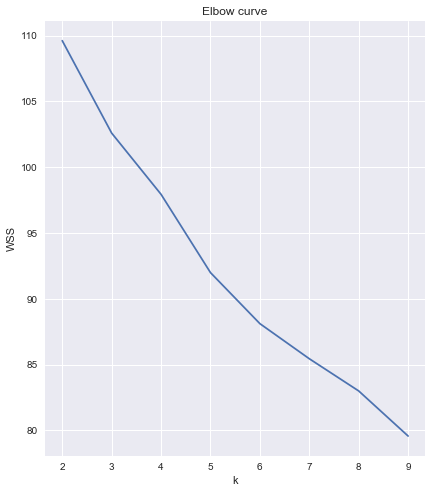

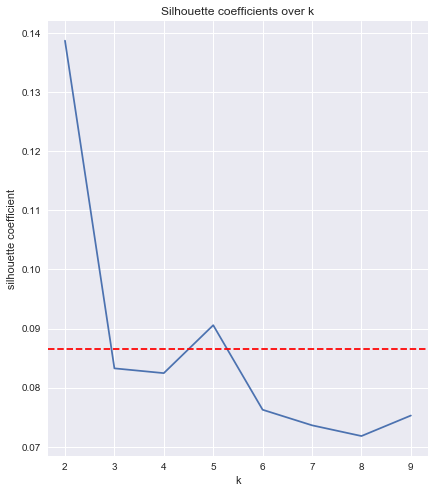

In [374]:
# run elbow and Silhouette methods to determine optimal k
helper.check_k_means(df_scaled)

In [375]:
# looks like k=5 might be appropriate, so let's try!

# fit the model with the scaled dataframe
model1 = helper.fit_k_means(5,df_scaled)

# create a new dataframe showing the clusters and scaled data
cluster_df1 = helper.create_cluster_df(model1,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df1['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_scaled.values, cluster_df1['cluster'])}")

Distribution of clusters:
1    60
4    58
3    37
2    35
0     1
Name: cluster, dtype: int64
Silhouette score: 0.08642274138545507


### Using subset of variables

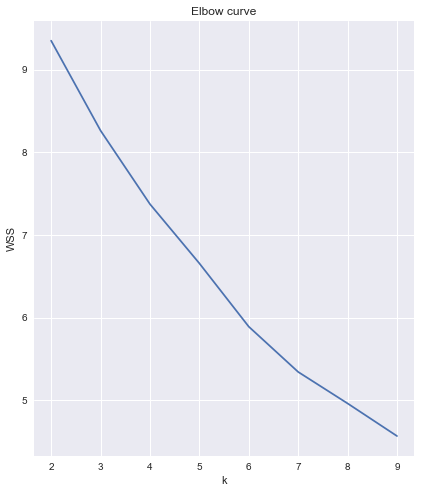

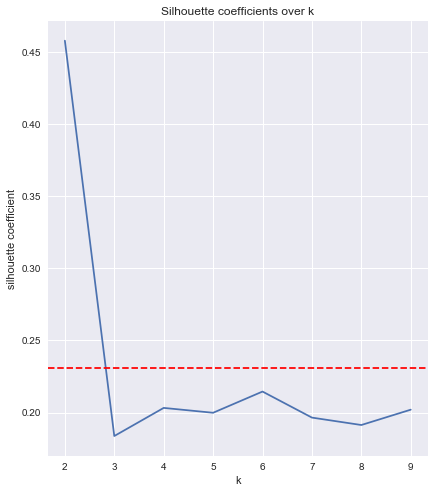

In [376]:
# let's try focusing on a few key variables that are traditional measures of gentrification
df_subset_scaled = df_scaled[['HINC00_PC','MHMVAL00_PC','MRENT00_PC','percent_owneroccupied_00_PC',
                              'percent_non-white00_PC','percent_4yrcollege_degree_ormore_PC']]

helper.check_k_means(df_subset_scaled)

In [377]:
# k=4 looks appropriate, let's try both

# fit the model with the scaled dataframe
model2 = helper.fit_k_means(4,df_subset_scaled)

# create a new dataframe showing the clusters and scaled data
cluster_df2 = helper.create_cluster_df(model2,df_subset_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df2['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_subset_scaled.values, cluster_df2['cluster'])}")
      
      # silhouette score went up!

Distribution of clusters:
0    83
3    77
1    24
2     7
Name: cluster, dtype: int64
Silhouette score: 0.2077152428352701


#### Optimize centroid location

In [383]:
# Some variables
SAMPLE_SIZE = 0.1
RANDOM_STATE = 42
NUM_CLUSTERS = 4     # k
NUM_ITER = 3          # n
NUM_ATTEMPTS = 10      # m

data_sample = df_subset_scaled.sample(frac=SAMPLE_SIZE, random_state=RANDOM_STATE, replace=False)
data_sample.shape

(19, 6)

In [392]:
final_cents = []
final_inert = []
    
for sample in range(NUM_ATTEMPTS):
    print('\nCentroid attempt: ', sample)
    km = KMeans(n_clusters=NUM_CLUSTERS, init='random', max_iter=1, n_init=1)#, verbose=1) 
    km.fit(data_sample)
    inertia_start = km.inertia_
    intertia_end = 0
    cents = km.cluster_centers_
        
    for iter in range(NUM_ITER):
        km = KMeans(n_clusters=NUM_CLUSTERS, init=cents, max_iter=1, n_init=1)
        km.fit(data_sample)
        print('Iteration: ', iter)
        print('Inertia:', km.inertia_)
        print('Centroids:', km.cluster_centers_)
        inertia_end = km.inertia_
        cents = km.cluster_centers_

    final_cents.append(cents)
    final_inert.append(inertia_end)
    print('Difference between initial and final inertia: ', inertia_start-inertia_end)


Centroid attempt:  0
Iteration:  0
Inertia: 0.7262224257582469
Centroids: [[0.36045371 0.30510068 0.47110165 0.52768188 0.12508846 0.43706384]
 [0.2770768  0.47077606 0.3977962  0.25405805 0.12870855 0.2897097 ]
 [0.19266675 0.46997914 0.3247224  0.17887054 0.13740843 0.22414867]
 [0.19481865 0.3003166  0.49710954 0.11658164 0.10703915 0.26583019]]
Iteration:  1
Inertia: 0.5758761470776181
Centroids: [[0.3669159  0.23256596 0.43732711 0.64696617 0.13335578 0.46716057]
 [0.29322657 0.46428716 0.40915926 0.25564679 0.13070213 0.30621863]
 [0.18810975 0.48029293 0.34250933 0.19742387 0.12725163 0.21837338]
 [0.19481865 0.3003166  0.49710954 0.11658164 0.10703915 0.26583019]]
Iteration:  2
Inertia: 0.3220308595250599
Centroids: [[0.23840021 0.         0.47421504 1.         0.09890525 0.35127212]
 [0.31953535 0.46953253 0.4133662  0.25752143 0.1415066  0.33570819]
 [0.19109731 0.46814958 0.34445158 0.21007177 0.11420255 0.22508845]
 [0.19481865 0.3003166  0.49710954 0.11658164 0.10703915 0

In [393]:
# Get best centroids to use for full clustering (in our case, 
# the metric is the lowest within-cluster sum-of-squares, or inertia).)
best_cents = final_cents[final_inert.index(min(final_inert))]
best_cents

array([[0.49543159, 0.46513191, 0.40043918, 0.29393234, 0.1678063 ,
        0.58304903],
       [0.20593435, 0.44962737, 0.38127964, 0.21347854, 0.10506136,
        0.23940584],
       [0.32878804, 0.47323804, 0.41394452, 0.25443289, 0.16148674,
        0.33314908],
       [0.23840021, 0.        , 0.47421504, 1.        , 0.09890525,
        0.35127212]])

In [394]:
km_full = KMeans(n_clusters=4, init=best_cents, max_iter=100, verbose=1, n_init=1).fit(df_subset_scaled)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 7.613090425701514
start iteration
done sorting
end inner loop
Iteration 1, inertia 7.523124334177272
start iteration
done sorting
end inner loop
Iteration 2, inertia 7.523124334177272
center shift 0.000000e+00 within tolerance 1.149723e-06


In [395]:
# create a new dataframe showing the clusters and scaled data
cluster_df2 = helper.create_cluster_df(km_full,df_subset_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df2['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_subset_scaled.values, cluster_df2['cluster'])}")
      
      # silhouette score went up!

Distribution of clusters:
2    82
1    77
0    31
3     1
Name: cluster, dtype: int64
Silhouette score: 0.19338670886124903


In [396]:
## merge this with original df of subset variables to look at summary stats
cluster_df2.set_index('tractid',inplace=True)

In [484]:
cluster_data_df = cluster_df2.merge(df_PC_subset_joined[['HINC00_PC','MHMVAL00_PC','MRENT00_PC','percent_owneroccupied_00_PC','percent_non-white00_PC',
                             'percent_4yrcollege_degree_ormore_PC']],how='outer',on='tractid')


## Agglomerative Hierarchical

Bottom up approach - starts with many small clusters then merges them together to create bigger clusters.

### Using all variables

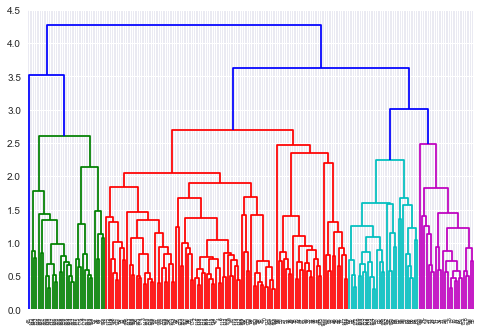

In [350]:
# we've already scaled the dataframe
# create a dendogram to determine optimal k
dendogram = sch.dendrogram(sch.linkage(df_scaled,method='ward'))

# k = 4?

In [351]:
model4 = AgglomerativeClustering(n_clusters=4,linkage='ward')
model4.fit(df_scaled.values)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func='deprecated')

In [352]:
# create a new dataframe showing the clusters and scaled data
cluster_df4 = helper.create_cluster_df(model4,df_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df4['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_scaled.values, cluster_df4['cluster'])}")
      
# not a great silhouette score, let's try subsetting hte df

Distribution of clusters:
2    104
0     54
1     32
3      1
Name: cluster, dtype: int64
Silhouette score: 0.07424592505624235


### Using subset of variables

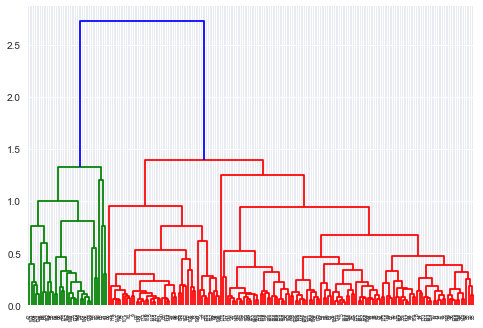

In [353]:
dendogram = sch.dendrogram(sch.linkage(df_subset_scaled,method='ward'))
# k=2

In [354]:
model5 = AgglomerativeClustering(n_clusters=2,linkage='ward')
model5.fit(df_subset_scaled.values)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=2,
            pooling_func='deprecated')

In [355]:
# create a new dataframe showing the clusters and scaled data
cluster_df5 = helper.create_cluster_df(model5,df_subset_scaled)

# observe the breakdown of clusters
print("Distribution of clusters:")
print(cluster_df5['cluster'].value_counts())

print(f"Silhouette score: {silhouette_score(df_subset_scaled.values, cluster_df5['cluster'])}")

Distribution of clusters:
0    157
1     34
Name: cluster, dtype: int64
Silhouette score: 0.4614688642905966


## Observing the clusters

In [398]:
# choose clusters resulting from agglomerative heirarchical
## Observe summary stats for each cluster to identify trends
cluster_data_df.groupby('cluster').describe()

HINC00_PC                                                         \
            count       mean        std        min        25%        50%   
cluster                                                                    
0            31.0  29.950377  45.555810 -35.189447   6.491471  23.978515   
1            77.0 -12.113974  17.424739 -78.580397 -19.896358  -9.881276   
2            82.0  19.248113  16.955154 -10.469426   6.078058  17.299901   
3             1.0  -6.763760        NaN  -6.763760  -6.763760  -6.763760   

                               MHMVAL00_PC                                     \
               75%         max       count        mean        std         min   
cluster                                                                         
0        50.486203  222.663616        31.0   87.356117  36.945887   11.276076   
1         0.103327   16.468261        77.0   72.581038  91.165987 -109.990999   
2        29.970803   74.229004        82.0   81.368938  30.948382   22.718319   
3        -6.763760   -6.763760         1.0 -426.250851        NaN -426.250851   

                                                        MRENT00_PC             \
                25%         50%         75%         max      count       mean   
cluster                                                                         
0         64.618147   84.461009  110.518847  167.702283       31.0  69.789266   
1         50.024004   69.530516   94.884725  658.879840       77.0  40.692898   
2         64.766897   77.627284   90.802194  211.730361       82.0  61.292303   
3       -426.250851 -426.250851 -426.250851 -426.250851        1.0  70.194001   

                                                                            \
               std        min        25%        50%        75%         max   
cluster                                                                      
0        54.352016 -17.805485  44.392121  52.593660  93.858815  226.734346   
1        25.601876 -70.992591  34.451220  46.421663  55.634512   86.187845   
2        22.697802   3.901437  47.809269  57.236877  69.839747  169.565217   
3              NaN  70.194001  70.194001  70.194001  70.194001   70.194001   

        percent_owneroccupied_00_PC                                     \
                              count        mean        std         min   
cluster                                                                  
0                              31.0   28.487215  47.173286  -18.522842   
1                              77.0   -7.447651  22.423771  -91.774845   
2                              82.0    7.341524  24.264395  -40.495872   
3                               1.0  278.179043        NaN  278.179043   

                                                         \
                25%         50%         75%         max   
cluster                                                   
0          2.797218   12.113011   31.320601  186.528846   
1        -10.995998   -3.796419    4.316139   36.785321   
2         -4.426292    2.237369   13.949978  161.796389   
3        278.179043  278.179043  278.179043  278.179043   

        percent_non-white00_PC                                              \
                         count       mean        std        min        25%   
cluster                                                                      
0                         31.0  11.238546  26.769124 -34.706979  -5.515875   
1                         77.0  22.159320  31.992980 -12.648678   0.249492   
2                         82.0  40.016484  81.914248 -45.339926   1.601634   
3                          1.0  20.704304        NaN  20.704304  20.704304   

                                          percent_4yrcollege_degree_ormore_PC  \
               50%        75%         max                               count   
cluster                                                                         
0         3.793878  19.610627   81.837191                            

In [485]:
# For now let's drop cluster 3 because the median home vlaue PC doesn't make sense 
cluster_data_df.drop(25025060700,axis=0,inplace=True)

In [ ]:
# cluster 0: 'gentrified'
# cluster 1: 'low income'
# cluster 2: "stable"
# cluster 3: 'other'

In [399]:
# what is the baseline? check these stats across all tracts
cluster_data_df.describe()

,cluster,HINC00_PC,MHMVAL00_PC,MRENT00_PC,percent_owneroccupied_00_PC,percent_non-white00_PC,percent_4yrcollege_degree_ormore_PC
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,1.277487,8.205588,76.140218,54.413525,6.229416,28.045647,36.730636
std,0.733747,29.495211,72.898621,32.937172,36.741160,59.206253,49.625312
min,0.000000,-78.580397,-426.250851,-70.992591,-91.774845,-45.339926,-68.782673
25%,1.000000,-8.199603,60.899670,41.721325,-7.328257,0.179394,6.286198
50%,1.000000,5.782489,75.964231,52.164264,1.096581,11.270011,22.950690
75%,2.000000,24.204165,93.834484,64.241557,11.682302,36.053877,50.875750
max,3.000000,222.663616,658.879840,226.734346,278.179043,622.412581,243.310830


In [486]:
def func(x):
    if x == 0:
        return 'Gentrifying'
    elif x==1:
        return 'Becoming more affordable'
    else:
        return 'Remaining costly'

In [487]:
cluster_data_df['cluster_name']=cluster_data_df['cluster'].apply(func)

In [488]:
cluster_data_df=cluster_data_df.round(2)

In [434]:
cluster_data_df.rename(columns={'HINC00_PC':'Percentage_Change_in_Median Household Income',
                                'MHMVCAL00_PC':'Percentage Change in Median Home Value',
                                'MRENT00_PC':'Percentage Change in Median Rent',
                                'MRENT00_PC':'Percentage Change in Median Rent',
                                'percent_owneroccupied_00_PC':'Percentage Change in Owner Occupied Housing',
                                'percent_non-white00_PC':'Percentage Change in Non-White Population',
                                'percent_4yrcollege_degree_ormore_PC':'Percentage Change in Population with 4YR College Degree'},inplace=True)



In [489]:
cluster_data_df.reset_index(level=0, inplace=True)

In [490]:
cluster_data_df.to_csv('CSV_files/clusters.csv')

In [ ]:
@app.callback(
    Output(component_id='my-graph',component_property='figure'),
    [Input(component_id='my-id',component_property='value')]
)def update_output_div(input_value):
     return f"You've entered {input_value}"

     